In [1]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time 

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx
import dimod

samplerSA = dimod.SimulatedAnnealingSampler()

import networkx as nx

sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [40]:
dataset = 'sp100_30' # values: 'asset_class','ftse','sectors','sp100' #coloring doesn't work with asset_class for some reason

os.chdir("../data_modified")

corr_tensor = np.load('%s_corr.npy' % (dataset))
dates = np.load('%s_dates.npy' % (dataset))
nodes = np.load('%s_nodes.npy' % (dataset))

num_examples = corr_tensor.shape[0] #number of dates
dim = corr_tensor.shape[1] #number of assets


In [41]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def coloring_score(G, coloring):
    count = 0
    for e in G.edges():
        v1, v2 = e
        if coloring[v1] == coloring[v2]:
            count += 1
        
        return count/G.number_of_edges()

In [42]:
# source code for DWave coloring algorithm - modified to include timing

from __future__ import division

import math
import itertools

import networkx as nx
from dwave_networkx import _PY2
from dwave_networkx.utils import binary_quadratic_model_sampler

__all__ = ["min_vertex_coloring", "is_vertex_coloring", "is_cycle"]

# compatibility for python 2/3
if _PY2:
    range = xrange

    def iteritems(d): return d.iteritems()

    def ceil(n): return int(math.ceil(n))
else:
    def iteritems(d): return d.items()
    ceil = math.ceil

try:
    import numpy
    eigenvalues = numpy.linalg.eigvals
except ImportError:
    eigenvalues = False



@binary_quadratic_model_sampler(1)
def min_vertex_coloring(G, sampler, temp,**sampler_args):

    # if the given graph is not connected, apply the function to each connected component
    # seperately.
    if not nx.is_connected(G):
        coloring = {}
        for subG in (G.subgraph(c).copy() for c in nx.connected_components(G)):
            sub_coloring = min_vertex_coloring(subG, sampler, temp, **sampler_args)
            coloring.update(sub_coloring)
        return coloring

    n_nodes = len(G)  # number of nodes
    n_edges = len(G.edges)  # number of edges

    # ok, first up, we can eliminate a few graph types trivially

    # Graphs with no edges, have chromatic number 1
    if not n_edges:
        return {node: 0 for node in G}

    # Complete graphs have chromatic number N
    if n_edges == n_nodes * (n_nodes - 1) // 2:
        return {node: color for color, node in enumerate(G)}

    # The number of variables in the QUBO is approximately the number of nodes in the graph
    # times the number of potential colors, so we want as tight an upper bound on the
    # chromatic number (chi) as possible
    chi_ub = _chromatic_number_upper_bound(G, n_nodes, n_edges)

    # now we can start coloring. Without loss of generality, we can determine some of
    # the node colors before trying to solve.
    partial_coloring, possible_colors, chi_lb = _partial_precolor(G, chi_ub)

    # ok, to get the rest of the coloring, we need to start building the QUBO. We do this
    # by assigning a variable x_v_c for each node v and color c. This variable will be 1
    # when node v is colored c, and 0 otherwise.

    # let's assign an index to each of the variables
    counter = itertools.count()
    x_vars = {v: {c: next(counter) for c in possible_colors[v]} for v in possible_colors}

    # now we have three different constraints we wish to add.

    # the first constraint enforces the coloring rule, that for each pair of vertices
    # u, v that share an edge, they should be different colors
    Q_neighbor = _vertex_different_colors_qubo(G, x_vars)

    # the second constraint enforces that each vertex has a single color assigned
    Q_vertex = _vertex_one_color_qubo(x_vars)

    # the third constraint is that we want a minimum vertex coloring, so we want to
    # disincentivize the colors we might not need.
    Q_min_color = _minimum_coloring_qubo(x_vars, chi_lb, chi_ub, magnitude=.75)

    # combine all three constraints
    Q = Q_neighbor
    for (u, v), bias in iteritems(Q_vertex):
        if (u, v) in Q:
            Q[(u, v)] += bias
        elif (v, u) in Q:
            Q[(v, u)] += bias
        else:
            Q[(u, v)] = bias
    for (v, v), bias in iteritems(Q_min_color):
        if (v, v) in Q:
            Q[(v, v)] += bias
        else:
            Q[(v, v)] = bias

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args) 
    computation_time = response.info['timing']['qpu_access_time'] / 10**6 #compute qpu access time, and convert to seconds 
    temp.append(computation_time)
    
    # we want the lowest energy sample
    sample = next(iter(response))

    # read off the coloring
    for v in x_vars:
        for c in x_vars[v]:
            if sample[x_vars[v][c]]:
                partial_coloring[v] = c
    
    return partial_coloring



def _chromatic_number_upper_bound(G, n_nodes, n_edges):
    # tries to determine an upper bound on the chromatic number of G
    # Assumes G is not complete

    # chi * (chi - 1) <= 2 * |E|
    quad_bound = ceil((1 + math.sqrt(1 + 8 * n_edges)) / 2)

    if n_nodes % 2 == 1 and is_cycle(G):
        # odd cycle graphs need three colors
        bound = 3
    else:
        if not eigenvalues:
            # chi <= max degree, unless it is complete or a cycle graph of odd length,
            # in which case chi <= max degree + 1 (Brook's Theorem)
            bound = max(G.degree(node) for node in G)
        else:
            # Let A be the adj matrix of G (symmetric, 0 on diag). Let theta_1
            # be the largest eigenvalue of A. Then chi <= theta_1 + 1 with
            # equality iff G is complete or an odd cycle.
            # this is strictly better than brooks theorem
            bound = ceil(max(eigenvalues(nx.to_numpy_matrix(G))))

    return min(quad_bound, bound)


def _minimum_coloring_qubo(x_vars, chi_lb, chi_ub, magnitude=1.):
    """We want to disincentivize unneeded colors. Generates the QUBO
    that does that.
    """
    # if we already know the chromatic number, then we don't need to
    # disincentivize any colors.
    if chi_lb == chi_ub:
        return {}

    # we might need to use some of the colors, so we want to disincentivize
    # them in increasing amounts, linearly.
    scaling = magnitude / (chi_ub - chi_lb)

    # build the QUBO
    Q = {}
    for v in x_vars:
        for f, color in enumerate(range(chi_lb, chi_ub)):
            idx = x_vars[v][color]
            Q[(idx, idx)] = (f + 1) * scaling

    return Q


def _vertex_different_colors_qubo(G, x_vars):

    Q = {}
    for u, v in G.edges:
        if u not in x_vars or v not in x_vars:
            continue
        for color in x_vars[u]:
            if color in x_vars[v]:
                Q[(x_vars[u][color], x_vars[v][color])] = 1.
    return Q


def _vertex_one_color_qubo(x_vars):

    Q = {}
    for v in x_vars:
        for color in x_vars[v]:
            idx = x_vars[v][color]
            Q[(idx, idx)] = -1

        for color0, color1 in itertools.combinations(x_vars[v], 2):
            idx0 = x_vars[v][color0]
            idx1 = x_vars[v][color1]

            Q[(idx0, idx1)] = 2

    return Q


def _partial_precolor(G, chi_ub):

    # find a random maximal clique and give each node in it a unique color
    v = next(iter(G))
    clique = [v]
    for u in G[v]:
        if all(w in G[u] for w in clique):
            clique.append(u)

    partial_coloring = {v: c for c, v in enumerate(clique)}
    chi_lb = len(partial_coloring)  # lower bound for the chromatic number

    # now for each uncolored node determine the possible colors
    possible_colors = {v: set(range(chi_ub)) for v in G if v not in partial_coloring}

    for v, color in iteritems(partial_coloring):
        for u in G[v]:
            if u in possible_colors:
                possible_colors[u].discard(color)

    # TODO: there is more here that can be done. For instance some nodes now
    # might only have one possible color. Or there might only be one node
    # remaining to color

    return partial_coloring, possible_colors, chi_lb


def is_cycle(G):

    trailing, leading = next(iter(G.edges))
    start_node = trailing

    # travel around the graph, checking that each node has degree exactly two
    # also track how many nodes were visited
    n_visited = 1
    while leading != start_node:
        neighbors = G[leading]

        if len(neighbors) != 2:
            return False

        node1, node2 = neighbors

        if node1 == trailing:
            trailing, leading = leading, node2
        else:
            trailing, leading = leading, node1

        n_visited += 1

    # if we haven't visited all of the nodes, then it is not a connected cycle
    return n_visited == len(G)


def is_vertex_coloring(G, coloring):
   
    return all(coloring[u] != coloring[v] for u, v in G.edges)

In [43]:
corr_mat = corr_tensor[int(num_examples/2), :, :].copy()

corr_mat[(corr_mat > -1*0.8) & (corr_mat < 0.8)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

In [44]:
density


0.135632183908046

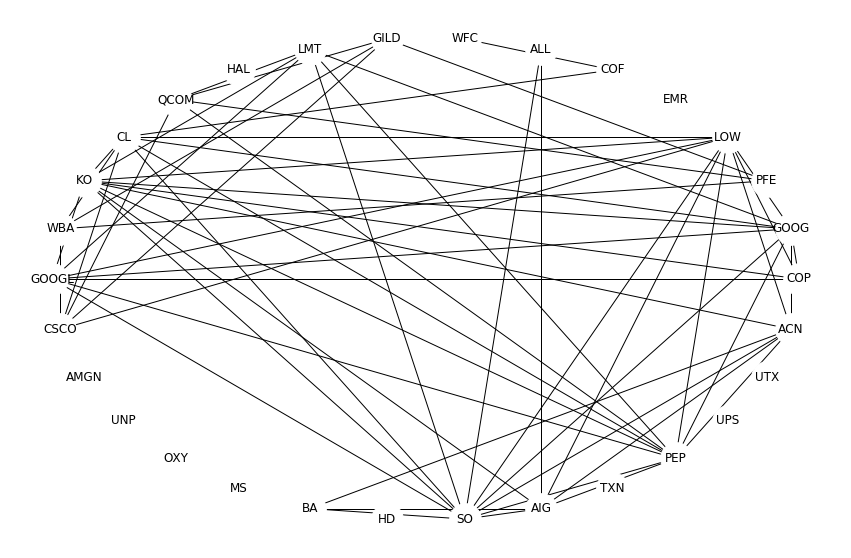

In [45]:
fig,ax = plt.subplots(figsize=(15,10))

nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="white")

In [46]:
fig.savefig('%s_high_density.png'%(dataset))

In [47]:
temp = []
coloring = min_vertex_coloring(G, sampler, temp)
computation_time = temp[0]
computation_time

0.008337

In [48]:
coloring

{'ACN': 5,
 'ALL': 0,
 'AMGN': 0,
 'BA': 1,
 'COF': 2,
 'COP': 0,
 'CSCO': 5,
 'EMR': 0,
 'GOOG': 1,
 'GOOGL': 4,
 'HAL': 0,
 'HD': 0,
 'KO': 3,
 'LMT': 2,
 'LOW': 2,
 'MS': 0,
 'OXY': 0,
 'SO': 6,
 'TXN': 0,
 'UNP': 0,
 'UPS': 0,
 'UTX': 0,
 'WFC': 3}

In [49]:
get_max_deg(G)

11

In [50]:
dnx.is_vertex_coloring(G, coloring)

KeyError: 'CL'

In [51]:
coloring


colors = []
for node in G.nodes():
    colors.append(coloring[node])


fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, 
                 node_color=list(colors), font_color="white")    # Plot graph density for each threshold. 

fig.savefig('gc_%s_HD'%(dataset))

thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)


KeyError: 'PFE'

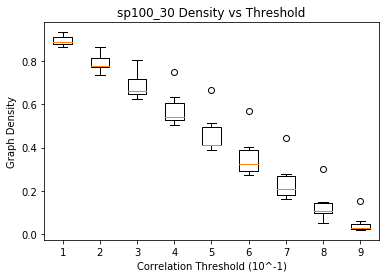

In [52]:
# Plot graph density for each threshold. 

thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)
    
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("%s Density vs Threshold" % (dataset))
plt.show()

In [53]:
# Create graph for each date and calculate best coloring using quantum computer. 

import time

coloring_array = []
valid_coloring_array = []
num_colors_array = []
date_array = []
density_array = []
threshold_array = []
time_array = []


count = 0
for i in np.arange(0.5, 1, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: 
            print("count: %d" % (count))
            
        try:
            opt_coloring = {}
            min_colors = dim
            
            for k in range(10):
                temp = []
                coloring = min_vertex_coloring(G, sampler, temp)
                computation_time = temp[0]
                num_colors = np.max(list(coloring.values())) + 1
                valid_coloring = dnx.is_vertex_coloring(G, coloring)
                
                if valid_coloring and num_colors < min_colors:
                    opt_coloring = coloring
                    min_colors = num_colors
            
            if opt_coloring == {}:
                raise Exception
                
        except Exception as err:
            print(err)
            print("Error on matrix %d with threshold %f" % (j*5, i))
        else:
            
            coloring_array.append(opt_coloring)
            num_colors_array.append(min_colors)
            valid_coloring_array.append(valid_coloring)
            time_array.append(computation_time)
            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])

no embedding found

KeyboardInterrupt: 

In [ ]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

In [ ]:
# Create Pandas DataFrame for quantum results
os.chdir("../result_files")

pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array, "computation_time":time_array}).to_csv("grphcolor_quant_%s_res.csv" % (dataset))

In [ ]:
# Run classical graph coloring algm on the matrices that ran successfully above
from networkx.algorithms.coloring import greedy_color

coloring_array = []
valid_coloring_array = []
num_colors_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        t = time.clock()
        coloring = greedy_color(G, strategy='independent_set')
        computation_time = time.clock() - t
        valid_coloring = dnx.is_vertex_coloring(G, coloring)
    except Exception as err:
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        num_colors = np.max(list(coloring.values())) + 1

        coloring_array.append(coloring)
        num_colors_array.append(num_colors)
        valid_coloring_array.append(valid_coloring)
        time_array.append(computation_time)
        density_array.append(density)

In [ ]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

In [ ]:
# Create Pandas DataFrame for classical results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array, "computation_time":time_array}).to_csv("grphcolor_class_%s_res.csv" % (dataset))

In [ ]:
# SA

import neal
solver = neal.SimulatedAnnealingSampler()

coloring_array = []
valid_coloring_array = []
num_colors_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        t = time.clock()
        coloring = dnx.min_vertex_coloring(G, solver)
        computation_time = time.clock() - t
        valid_coloring = dnx.is_vertex_coloring(G, coloring)
    except Exception as err:
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        num_colors = np.max(list(coloring.values())) + 1

        coloring_array.append(coloring)
        num_colors_array.append(num_colors)
        valid_coloring_array.append(valid_coloring)
        time_array.append(computation_time)
        density_array.append(density)

In [ ]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

# Create Pandas DataFrame for SA results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array, "computation_time":time_array}).to_csv("grphcolor_SA_%s_res.csv" % (dataset))

In [ ]:
# Compare classical vs quantum
quant_res_df = pd.read_csv("grphcolor_quant_%s_res.csv" % (dataset))
class_res_df = pd.read_csv("grphcolor_class_%s_res.csv" % (dataset))



<Figure size 432x288 with 0 Axes>

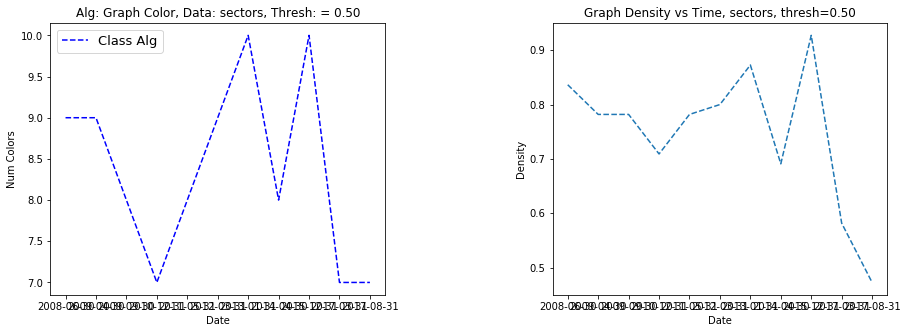

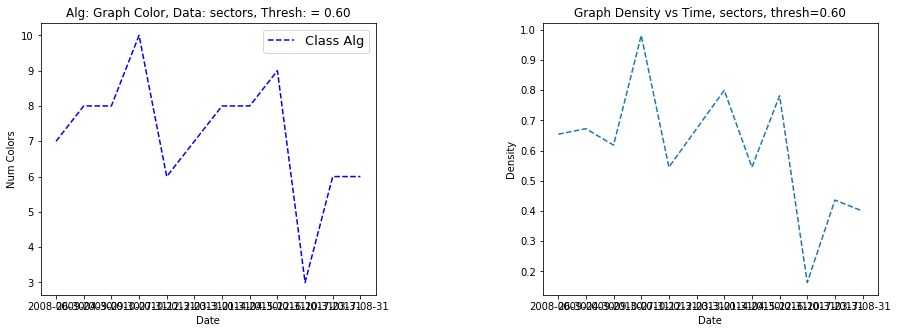

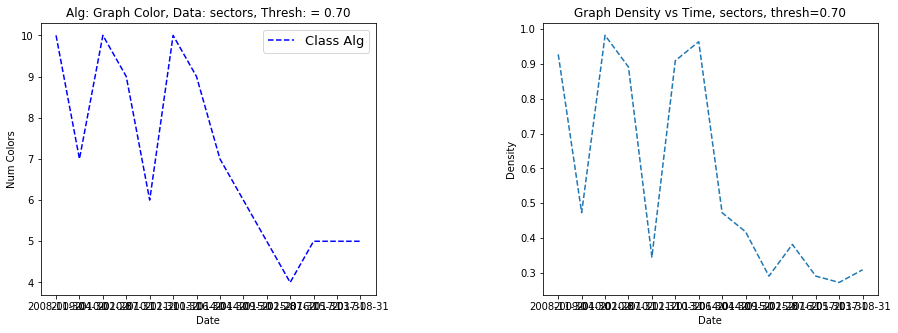

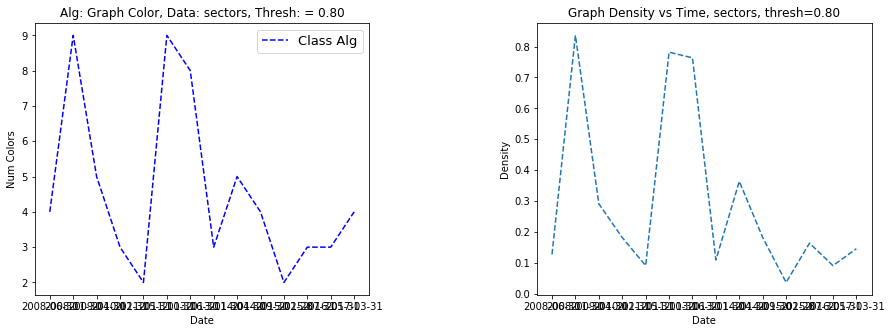

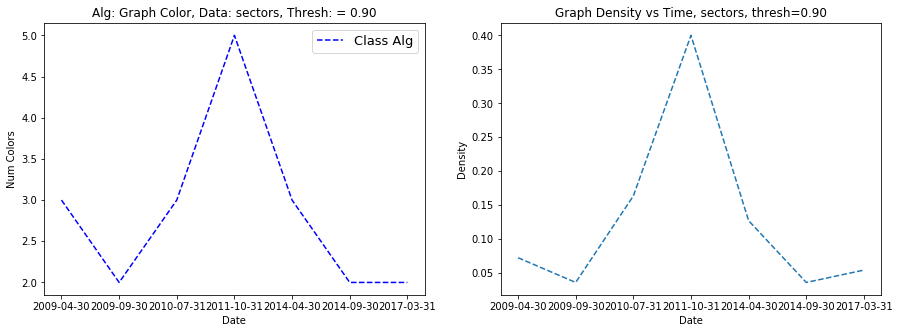

In [216]:
# Plot score vs time for each threshold
thresholds = class_res_df['threshold'].unique()

i = 1
for thresh in thresholds:
    class_series = class_res_df[(class_res_df.threshold == thresh)]

    fig = plt.figure(i)
    plt.subplots_adjust(wspace=0.5)
    plt.subplots(figsize=(15,5))
    
    plt.subplot(121)
    plt.title('Alg: Graph Color, Data: %s, Thresh: = %.2f' % (dataset, thresh))
    plt.ylabel('Num Colors')
    plt.xlabel('Date')
    
    plt.plot(class_series['date'], class_series['num_colors'], 'b--', label='Class Alg')
    plt.legend(loc=0, prop={'size': 13})
#     plt.xticks(ticks=class_series['date'][::3], labels=[x[0:7] for x in class_series['date']])
    
    plt.subplot(122)
    plt.title('Graph Density vs Time, %s, thresh=%.2f' % (dataset, thresh))
    plt.plot(class_series['date'], class_series['density'], '--')
    #plt.xticks(ticks=class_series['date'][::3], labels=[x[0:7] for x in class_series['date']])
    plt.ylabel("Density")
    plt.xlabel("Date")
    
    i += 1

Text(0.5, 0, 'Date')

<Figure size 432x288 with 0 Axes>

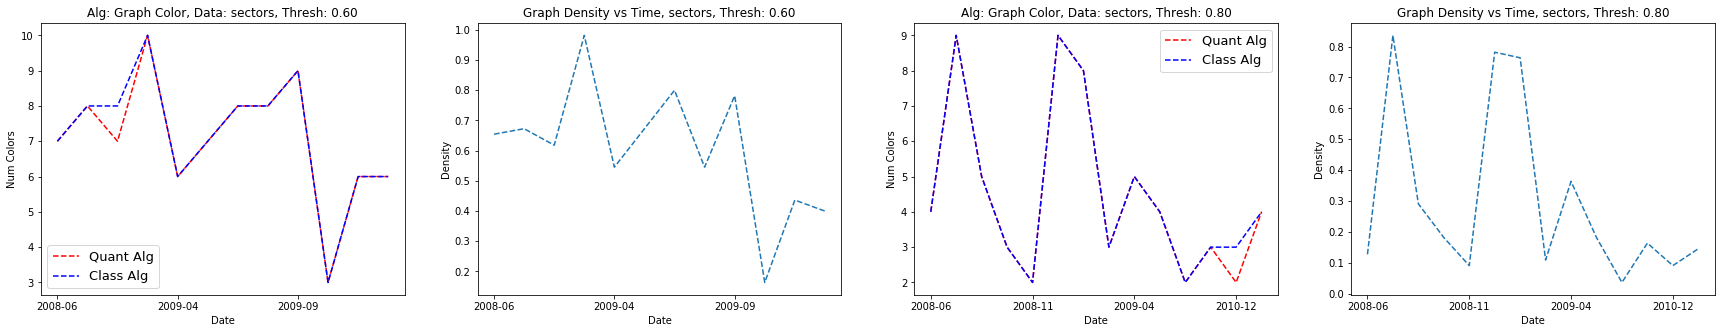

In [217]:
# Plot score vs time for each threshold
thresholds = quant_res_df['threshold'].unique()
low_thresh = thresholds[1]
high_thresh = thresholds[3]

quant_series = quant_res_df[(quant_res_df.threshold == low_thresh) & 
                            (quant_res_df.valid_coloring == True)]
class_series = class_res_df[(class_res_df.threshold == low_thresh) & 
                            (class_res_df.valid_coloring == True)]
class_series = class_series[class_series['date'].isin(quant_series['date'])]

assert quant_series.shape == class_series.shape

fig = plt.figure(1)
plt.subplots(figsize=(30,5))

plt.subplot(141)
plt.title('Alg: Graph Color, Data: %s, Thresh: %.2f' % (dataset, low_thresh))
plt.ylabel('Num Colors')
plt.xlabel('Date')

plt.plot(quant_series["date"], quant_series['num_colors'], 'r--', label='Quant Alg')
plt.plot(quant_series["date"], class_series['num_colors'], 'b--', label='Class Alg')
plt.legend(loc=0, prop={'size': 13})
plt.xticks(ticks=quant_series['date'][::4], 
          labels=[x[0:7] for x in quant_series['date']])

plt.subplot(142)
plt.title('Graph Density vs Time, %s, Thresh: %.2f' % (dataset, low_thresh))
plt.plot(quant_series['date'], quant_series['density'], '--')
plt.xticks(ticks=quant_series['date'][::4], 
          labels=[x[0:7] for x in quant_series['date']])
plt.ylabel("Density")
plt.xlabel("Date")


quant_series = quant_res_df[(quant_res_df.threshold == high_thresh) & 
                            (quant_res_df.valid_coloring == True)]
class_series = class_res_df[(class_res_df.threshold == high_thresh) & 
                            (class_res_df.valid_coloring == True)]
class_series = class_series[class_series['date'].isin(quant_series['date'])]

assert quant_series.shape == class_series.shape

plt.subplot(143)
plt.title('Alg: Graph Color, Data: %s, Thresh: %.2f' % (dataset, high_thresh))
plt.ylabel('Num Colors')
plt.xlabel('Date')

plt.plot(quant_series["date"], quant_series['num_colors'], 'r--', label='Quant Alg')
plt.plot(quant_series["date"], class_series['num_colors'], 'b--', label='Class Alg')
plt.legend(loc=0, prop={'size': 13})
plt.xticks(ticks=quant_series['date'][::4], 
          labels=[x[0:7] for x in quant_series['date']])

plt.subplot(144)
plt.title('Graph Density vs Time, %s, Thresh: %.2f' % (dataset, high_thresh))
plt.plot(quant_series['date'], quant_series['density'], '--')
plt.xticks(ticks=quant_series['date'][::4], 
          labels=[x[0:7] for x in quant_series['date']])
plt.ylabel("Density")
plt.xlabel("Date")

ConversionError: Failed to convert value(s) to axis units: array(['2008-06-30', '2009-04-30', '2009-09-30', '2010-12-31',
       '2011-05-31', '2012-03-31', '2013-01-31', '2014-04-30',
       '2015-12-31', '2017-03-31', '2017-08-31', '2008-06-30',
       '2009-04-30', '2009-09-30', '2010-07-31', '2010-12-31',
       '2012-03-31', '2013-01-31', '2014-04-30', '2015-12-31',
       '2016-10-31', '2017-03-31', '2017-08-31', '2008-11-30',
       '2009-04-30', '2010-02-28', '2010-07-31', '2010-12-31',
       '2011-10-31', '2013-06-30', '2014-04-30', '2014-09-30',
       '2015-02-28', '2015-07-31', '2016-05-31', '2017-03-31',
       '2017-08-31', '2008-06-30', '2008-11-30', '2009-04-30',
       '2010-12-31', '2011-05-31', '2011-10-31', '2013-06-30',
       '2013-11-30', '2014-04-30', '2014-09-30', '2015-02-28',
       '2015-07-31', '2016-05-31', '2017-03-31', '2009-04-30',
       '2009-09-30', '2010-07-31', '2011-10-31', '2014-04-30',
       '2014-09-30', '2017-03-31'], dtype=object)

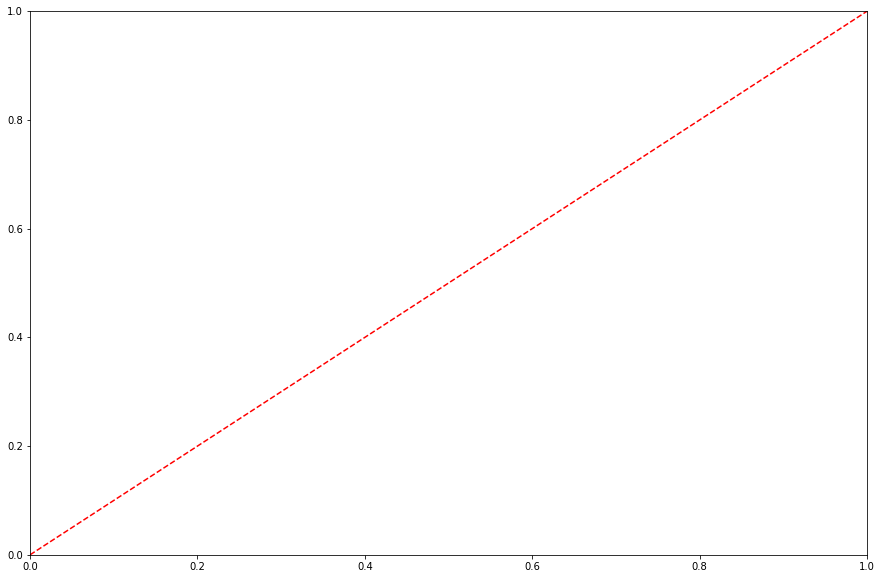

In [218]:
fig = plt.figure(1, figsize=(15,10))
plt.plot(quant_res_df, 'r--', label='Quant Alg')
plt.plot(class_res_df, 'b--', label='Class. Alg')
plt.title("Min Colors vs Density")
plt.ylabel("Num Colors")
plt.xlabel("Density")
plt.legend(loc=0)
plt.show()